In [96]:
import os
import sys
import time
import warnings
os.system('clear')
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.data as data

import importlib

In [70]:
sys.path.append('../Code/')

In [117]:
# Load Dataset, assuming its already been calculated
if 'ProcDS' not in globals():
    ProcDS = torch.load('./AllRuns.pt')
    # Unfuck the Truth Xmax
    ProcDS._Truth[:,0] = ((ProcDS._Truth[:,0]+750)*70 -750)/70
    ProcDS._Rec  [:,0] = ((ProcDS._Rec  [:,0]+750)*70 -750)/70
    ProcDS.AssignIndices()

def Unnormalise_Xmax_Energy(Data):
    Data[:,0] = Data[:,0]*70+750
    Data[:,1] = Data[:,1]+19
    return Data

ProcDS.Unnormalise_Truth = Unnormalise_Xmax_Energy
ProcDS.BatchSize = 128
ProcDS.RandomIter = True

In [72]:
# Define Some Paths
SavePath     = '.'
plotSavePath = './TrainingPlots/'
LogPath      = '/remote/tychodata/ftairli/work/Projects/TrainingLogs/'

if plotSavePath != None:  # Purge the directory
        os.system(f'rm -r {plotSavePath}')
        os.system(f'mkdir {plotSavePath}')



In [73]:
for _,Main,Aux,Truth,Rec in ProcDS:
    Main = Main[0]
    print(Main.shape)
    
    break

torch.Size([128, 400])


In [74]:
# Xmax = ProcDS._Truth[:,0]
# LogE = ProcDS._Truth[:,1]

# plt.figure(figsize=(10,10))
# plt.hist(Xmax.numpy(),bins=100)

In [75]:
# Define Loss, Validation and Metric Here

def Loss(Pred,Truth,keys=['Xmax','LogE'],ReturnTensor = True):

    '''
    Calculates MSE Loss for all the keys in the keys list
    '''
    assert Pred.shape == Truth.shape, f'Pred Shape: {Pred.shape}, Truth Shape: {Truth.shape} not equal'
    Truth = Truth.to(Pred.device)
    # Calculate Loss
    losses = {}
    for i,key in enumerate(keys):
        losses[key] = F.mse_loss(Pred[:,i],Truth[:,i])
    
    losses['Total'] = sum(losses.values())
    if ReturnTensor: return losses
    else:
        losses = {key:loss.item() for key,loss in losses.items()}
        return losses


def validate(model,Dataset,Loss,device,BatchSize = 256):
    '''
    Takes model, Dataset, Loss Function, device, keys
    Dataset is defined as ProcessingDatasetContainer in the Dataset2.py
    keys are to be used in the loss function
    BatchSize to change in case it doesnt fit into memory
    Returns the average loss
    '''
    # make sure the Dataset State is Val
    Dataset.State = 'Val'
    model.eval()
    TrainingBatchSize = Dataset.BatchSize
    Dataset.BatchSize = BatchSize
    Preds  = []
    Truths = []
    with torch.no_grad():
        for _, BatchMains, BatchAux, BatchTruth,_  in Dataset:
            
            Preds .append( model(BatchMains,BatchAux).to('cpu'))
            Truths.append(       BatchTruth          .to('cpu'))
        Preds  = torch.cat(Preds ,dim=0)
        Truths = torch.cat(Truths,dim=0)

    # Return Batch Size to old value
    Dataset.BatchSize = TrainingBatchSize
    return Loss(Preds,Truths,keys=Dataset.Truth_Keys,ReturnTensor=False)


def metric(model,Dataset,device,keys = ['Xmax','LogE'],BatchSize = 256):
    '''
    Takes model, Dataset, Loss Function, device, keys
    Dataset is defined as ProcessingDatasetContainer in the Dataset2.py
    keys are to be used in the loss function
    BatchSize to change in case it doesnt fit into memory
    Returns the 68% containment range of the angular deviation
    '''
    # make sure the Dataset State is Val
    Dataset.State = 'Val'
    model.eval()
    TrainingBatchSize = Dataset.BatchSize
    Dataset.BatchSize = BatchSize
    Preds  = []
    Truths = []
    with torch.no_grad():
        for _, BatchMains, BatchAux, BatchTruth, _ in Dataset:
            Preds .append( model(BatchMains,BatchAux).to('cpu'))
            Truths.append(       BatchTruth          .to('cpu'))
    Preds  = torch.cat(Preds ,dim=0).cpu()
    Truths = torch.cat(Truths,dim=0).cpu()
    Preds  = Dataset.Unnormalise_Truth(Preds )
    Truths = Dataset.Unnormalise_Truth(Truths)

    Units = Dataset.Truth_Units
    metrics = {}
    for i,key in enumerate(keys):
        if Units[i] == 'rad':
            AngDiv = torch.atan2(torch.sin(Preds[:,i]-Truths[:,i]),torch.cos(Preds[:,i]-Truths[:,i]))
            metrics[key] = torch.quantile(torch.abs(AngDiv),0.68)
        if Units[i] == 'deg':
            AngDiv = torch.atan2(torch.sin(torch.deg2rad(Preds[:,i]-Truths[:,i])),torch.cos(torch.deg2rad(Preds[:,i]-Truths[:,i])))
            metrics[key] = torch.quantile(torch.abs(AngDiv),0.68)*180/torch.pi
        else:
            metrics[key] = torch.quantile(torch.abs(Preds[:,i]-Truths[:,i]),0.68)
    # Return Batch Size to old value
    Dataset.BatchSize = TrainingBatchSize
    return metrics


In [118]:
# Define Model Here

class Model_XmaxE_Conv1D(nn.Module):

    Name = 'Model_XmaxE_Conv1D'
    Description = 'Model to predict Xmax and Energy using Conv1D'


    def __init__(self,N_kernels_init = 16, N_kernels_post = 16, N_dense_nodes = 128, **kwargs):
        self.kwargs = kwargs
        super(Model_XmaxE_Conv1D, self).__init__()

        # Input is a 1 channels of 400 bins each
        
        # Initial Convolutional Layers
        # Lets do different kernel sizes and different dilation and make sure they all end up the same size name scheme is Conv_{kernel_size}_{dilation}
        # stride is always 2 for the initial layers
        
        # dilation is either 1 or 3
        # kernel size is either 3 or 5 or 7 or 9
        self.Conv_3_1 = nn.Conv1d(1,N_kernels_init,kernel_size=3,dilation = 1, padding = 1,stride = 2) # 400 -> 200
        # self.Conv_3_2 = nn.Conv1d(1,N_kernels_init,kernel_size=3,dilation = 2, padding = 2,stride = 2) 
        # self.Conv_3_3 = nn.Conv1d(1,N_kernels_init,kernel_size=3,dilation = 3, padding = 3,stride = 2)

        self.Conv_5_1 = nn.Conv1d(1,N_kernels_init,kernel_size=5,dilation = 1, padding = 2,stride = 2) # 400 -> 200
        # self.Conv_5_2 = nn.Conv1d(1,N_kernels_init,kernel_size=5,dilation = 2, padding = 4,stride = 2)
        # self.Conv_5_3 = nn.Conv1d(1,N_kernels_init,kernel_size=5,dilation = 3, padding = 6,stride = 2)

        self.Conv_7_1 = nn.Conv1d(1,N_kernels_init,kernel_size=7,dilation = 1, padding = 3,stride = 2) # 400 -> 200
        # self.Conv_7_2 = nn.Conv1d(1,N_kernels_init,kernel_size=7,dilation = 2, padding = 6,stride = 2)
        # self.Conv_7_3 = nn.Conv1d(1,N_kernels_init,kernel_size=7,dilation = 3, padding = 9,stride = 2)

        self.Conv_9_1 = nn.Conv1d(1,N_kernels_init,kernel_size=9,dilation = 1, padding = 4,stride = 2) # 400 -> 200
        # self.Conv_9_2 = nn.Conv1d(1,N_kernels_init,kernel_size=9,dilation = 2, padding = 8,stride = 2)
        # self.Conv_9_3 = nn.Conv1d(1,N_kernels_init,kernel_size=9,dilation = 3, padding = 12,stride = 2)

        # Post Convolutional Layers

        self.Post_Conv_1 = nn.Conv1d(4*N_kernels_init,N_kernels_post,kernel_size=5, padding = 2) # 200 -> 200
        self.Pool1 = nn.MaxPool1d(2) # 200 -> 100
        self.Post_Conv_2 = nn.Conv1d(  N_kernels_post,N_kernels_post,kernel_size=3, padding = 1) # 100 -> 100
        self.Pool2 = nn.MaxPool1d(2) # 100 -> 50
        self.Post_Conv_3 = nn.Conv1d(  N_kernels_post,N_kernels_post,kernel_size=3, padding = 1) # 50 -> 50
        self.Pool3 = nn.MaxPool1d(2) # 50 -> 25
        self.Post_Conv_4 = nn.Conv1d(  N_kernels_post,N_kernels_post,kernel_size=3, padding = 1) # 25 -> 25
        self.Pool4 = nn.MaxPool1d(2) # 25 -> 12
        self.Post_Conv_5 = nn.Conv1d(  N_kernels_post,N_kernels_post,kernel_size=3, padding = 1) # 12 -> 12

        # Dense Layers
        self.Dense_1 = nn.Linear(12*N_kernels_post,N_dense_nodes)
        self.Dense_2 = nn.Linear(    N_dense_nodes,N_dense_nodes//2)
        self.Dense_3 = nn.Linear(    N_dense_nodes//2,2)

        self.Conv_Activation = nn.ReLU()
        self.Dense_Activation = nn.LeakyReLU()

    def forward(self,x,aux):
        x = x[0].unsqueeze(1)  # x is the Main Data object and therefore is a tuple of length 1
        
        device = self.Dense_1.weight.device
        x = x.to(device)
        # aux = aux.to(device) # not using aux for now
        
        # Initial Convolutional Layers
        x1 = self.Conv_Activation(self.Conv_3_1(x))
        # x2 = self.Conv_Activation(self.Conv_3_2(x))
        # x3 = self.Conv_Activation(self.Conv_3_3(x))

        x4 = self.Conv_Activation(self.Conv_5_1(x))
        # x5 = self.Conv_Activation(self.Conv_5_2(x))
        # x6 = self.Conv_Activation(self.Conv_5_3(x))

        x7 = self.Conv_Activation(self.Conv_7_1(x))
        # x8 = self.Conv_Activation(self.Conv_7_2(x))
        # x9 = self.Conv_Activation(self.Conv_7_3(x))

        x10 = self.Conv_Activation(self.Conv_9_1(x))
        # x11 = self.Conv_Activation(self.Conv_9_2(x))
        # x12 = self.Conv_Activation(self.Conv_9_3(x))

        # Concatenate the results
        # x = torch.cat([x1,x3,x4,x6,x7,x9,x10,x12],dim=1)
        x = torch.cat([x1,x4,x7,x10],dim=1)

        # Post Convolutional Layers
        x = self.Conv_Activation(self.Post_Conv_1(x))
        x = self.Pool1(x)
        x = self.Conv_Activation(self.Post_Conv_2(x))
        x = self.Pool2(x)
        x = self.Conv_Activation(self.Post_Conv_3(x))
        x = self.Pool3(x)
        x = self.Conv_Activation(self.Post_Conv_4(x))
        x = self.Pool4(x)
        x = self.Conv_Activation(self.Post_Conv_5(x))

        # Dense Layers 
        x = x.view(x.shape[0],-1)
        x = self.Dense_Activation(self.Dense_1(x))
        x = self.Dense_Activation(self.Dense_2(x))
        x = self.Dense_3(x)
        x[:,0] = 0
        return x

In [77]:
def Lout(kernel_size,dilation,padding,in_size = 400, stride = 2):
    return int((in_size + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1)

def needed_padding(kernel_size,dilation):
    in_size = 400
    out_size = 200
    padding = 0
    while out_size != Lout(kernel_size,dilation,padding):
        # print(Lout(kernel_size,dilation,padding))
        padding += 1
        if padding > 100: break
    return padding



for kernel_size in [3,5,7,9]:
    print()
    for dilation in [1,2,3]:
        print(f'Kernel Size: {kernel_size}, Dilation: {dilation}, Padding: {needed_padding(kernel_size,dilation)}')
# needed_padding(3,0)


Kernel Size: 3, Dilation: 1, Padding: 1
Kernel Size: 3, Dilation: 2, Padding: 2
Kernel Size: 3, Dilation: 3, Padding: 3

Kernel Size: 5, Dilation: 1, Padding: 2
Kernel Size: 5, Dilation: 2, Padding: 4
Kernel Size: 5, Dilation: 3, Padding: 6

Kernel Size: 7, Dilation: 1, Padding: 3
Kernel Size: 7, Dilation: 2, Padding: 6
Kernel Size: 7, Dilation: 3, Padding: 9

Kernel Size: 9, Dilation: 1, Padding: 4
Kernel Size: 9, Dilation: 2, Padding: 8
Kernel Size: 9, Dilation: 3, Padding: 12


In [78]:
Lout(5,1,2,in_size=100,stride = 1)

100

In [119]:
# Load the model and axuillary functions
import TrainingModule
importlib.reload(TrainingModule)
Tracker = TrainingModule.Tracker
Train   = TrainingModule.Train

Model = Model_XmaxE_Conv1D

Loss_function = Loss
# validate      = validate
# metric        = metric


# Setup the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Model Parameters
Model_Parameters = {
    'in_main_channels': (3,),
    'in_node_channels': 5   ,
    'in_edge_channels': 2   ,
    'in_aux_channels' : 1   ,
    'N_kernels'       : 16   ,
    'N_Graph_Heads'   : 2   ,
    'N_dense_nodes'   : 1128  ,
    'N_LSTM_nodes'    : 64  ,
    'N_LSTM_layers'   : 5   ,
    'kernel_size'     : 10  ,
    'conv2d_init_type': 'normal',
    'model_Dropout'   : 0.2
    }


Training_Parameters = {
        'LR': 0.0001,
        'epochs': 5,
        'BatchSize': ProcDS.BatchSize, # In notebook set during loading
        'accumulation_steps': 1,
        'epoch_done': 0,
        'batchBreak': 1e99,
        'ValLossIncreasePatience': 15,
        'Optimizer': 'Adam'
    }


model = Model(**Model_Parameters).to(device)

if Training_Parameters['Optimizer'] == 'Adam': optimizer = optim.Adam(model.parameters(), lr=Training_Parameters['LR'])
if Training_Parameters['Optimizer'] == 'SGD' : optimizer = optim.SGD (model.parameters(), lr=Training_Parameters['LR'], momentum=0.9)
# Define scheduler
gamma = 0.001**(1/30) if Training_Parameters['epochs']>30 else 0.001**(1/Training_Parameters['epochs']) # Reduce the LR by factor of 1000 over 30 epochs or less
scheduler = torch.optim.lr_scheduler.ExponentialLR    (optimizer, gamma = gamma, last_epoch=-1, verbose=False)



Epoch 1/5
Batch 4050  /4050 - Loss: 0.6800
Calculating Val Metrics
Epoch Loss: 0.9185 | Epoch Val Loss: 0.9121
Xmax : 62.6174 g/cm^2 |LogE : 0.0361  |
Plotting
Epoch 2/5
Batch 4050  /4050 - Loss: 1.0751
Calculating Val Metrics
Epoch Loss: 0.9092 | Epoch Val Loss: 0.9117
Xmax : 62.6174 g/cm^2 |LogE : 0.0323  |
Plotting
Epoch 3/5
Batch 4050  /4050 - Loss: 0.6025
Calculating Val Metrics
Epoch Loss: 0.9090 | Epoch Val Loss: 0.9116
Xmax : 62.6174 g/cm^2 |LogE : 0.0311  |
Plotting
Epoch 4/5
Batch 4050  /4050 - Loss: 0.8748
Calculating Val Metrics
Epoch Loss: 0.9089 | Epoch Val Loss: 0.9116
Xmax : 62.6174 g/cm^2 |LogE : 0.0309  |
Plotting
Epoch 5/5
Batch 4050  /4050 - Loss: 0.7592
Calculating Val Metrics
Epoch Loss: 0.9089 | Epoch Val Loss: 0.9116
Xmax : 62.6174 g/cm^2 |LogE : 0.0309  |
Plotting


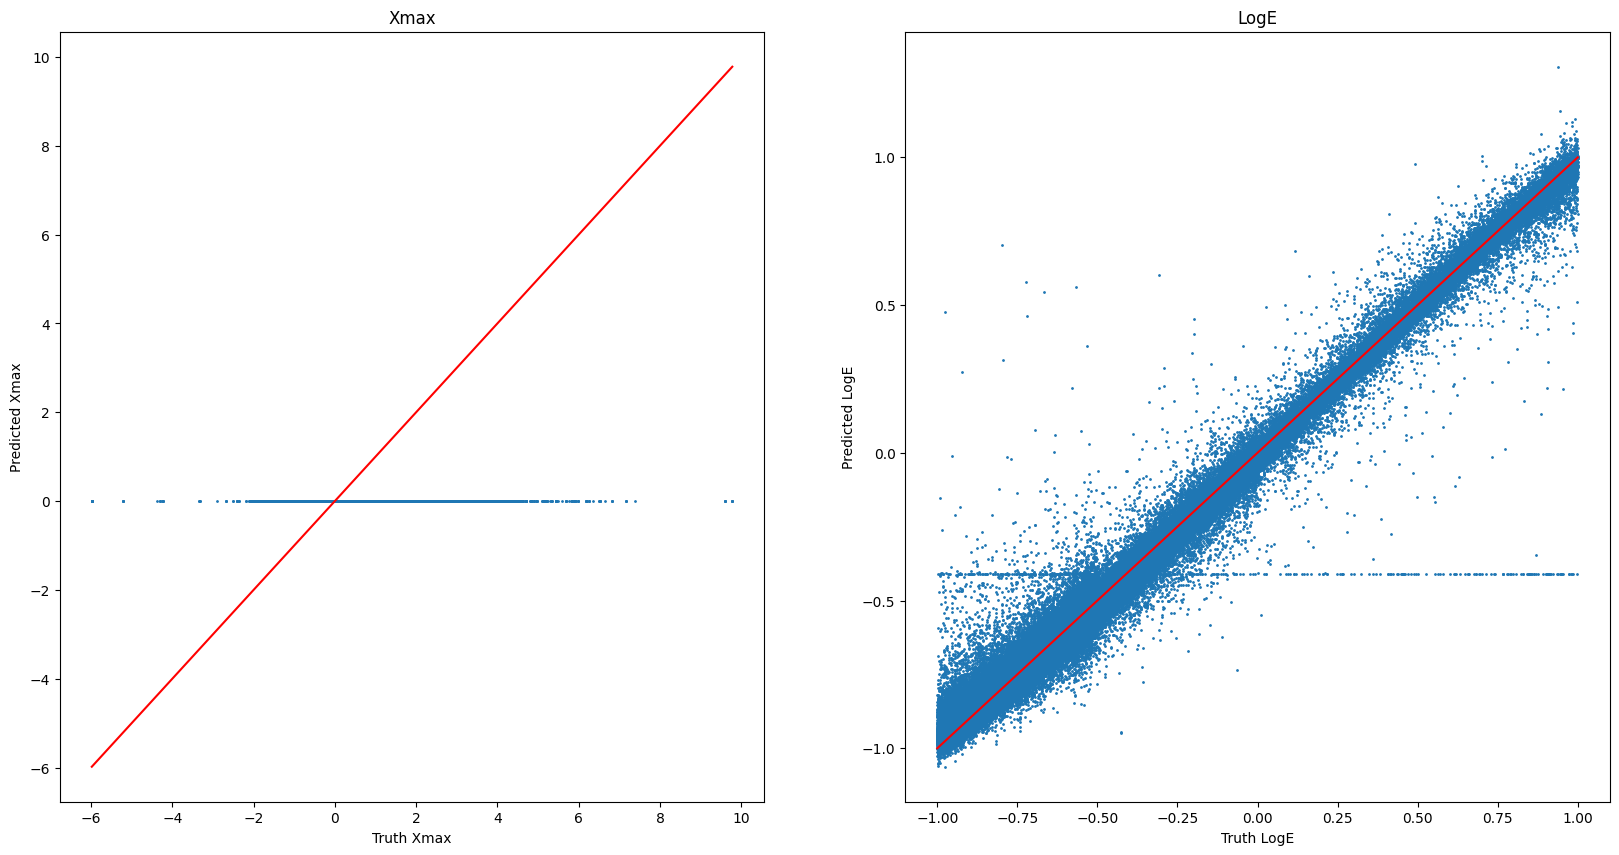

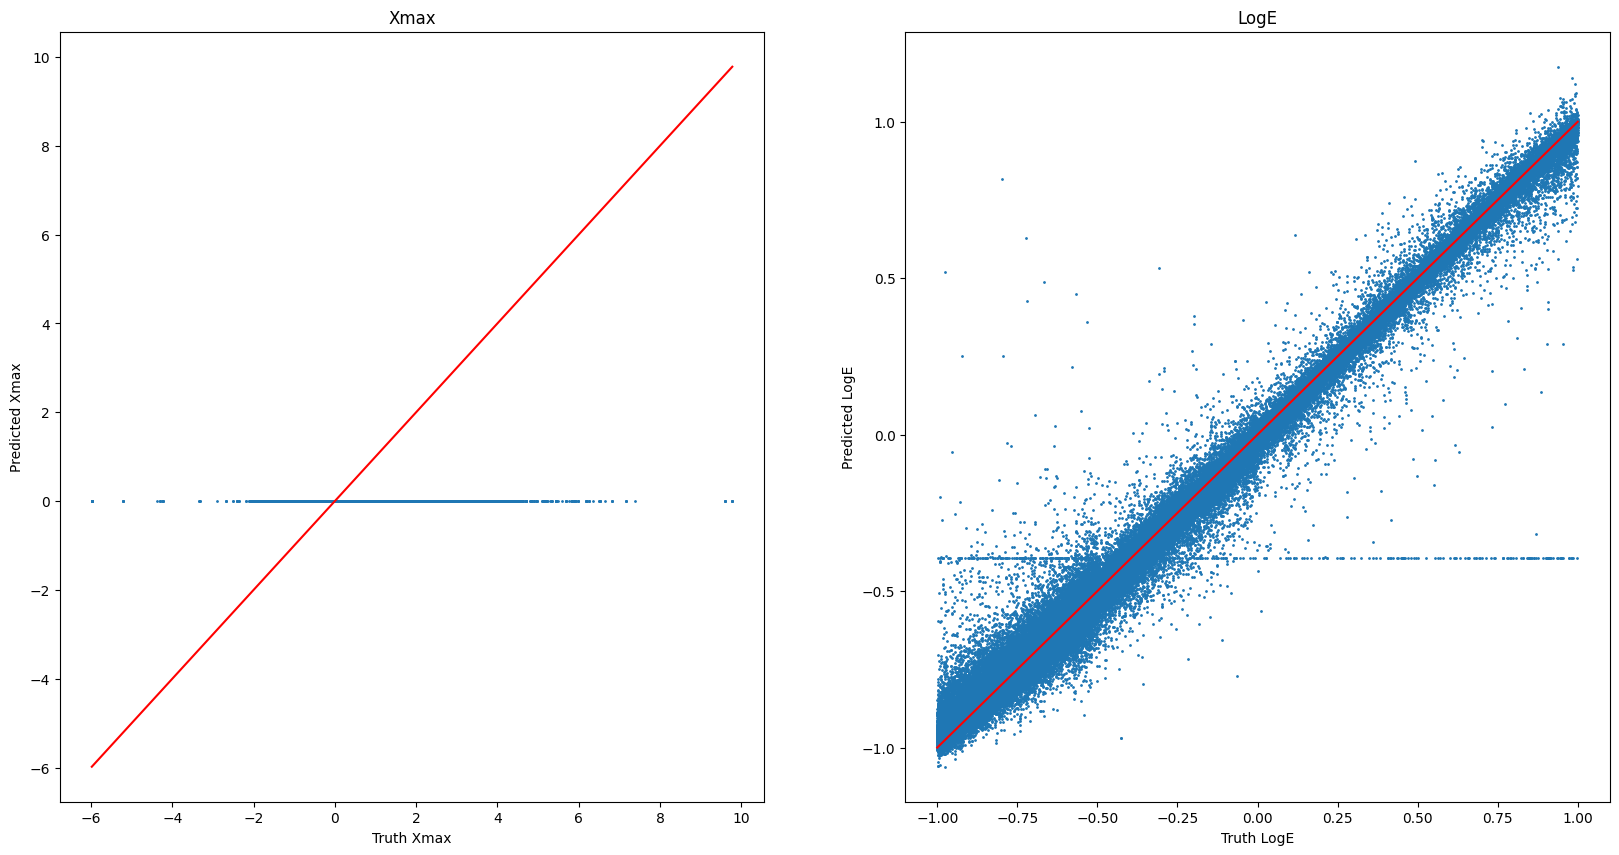

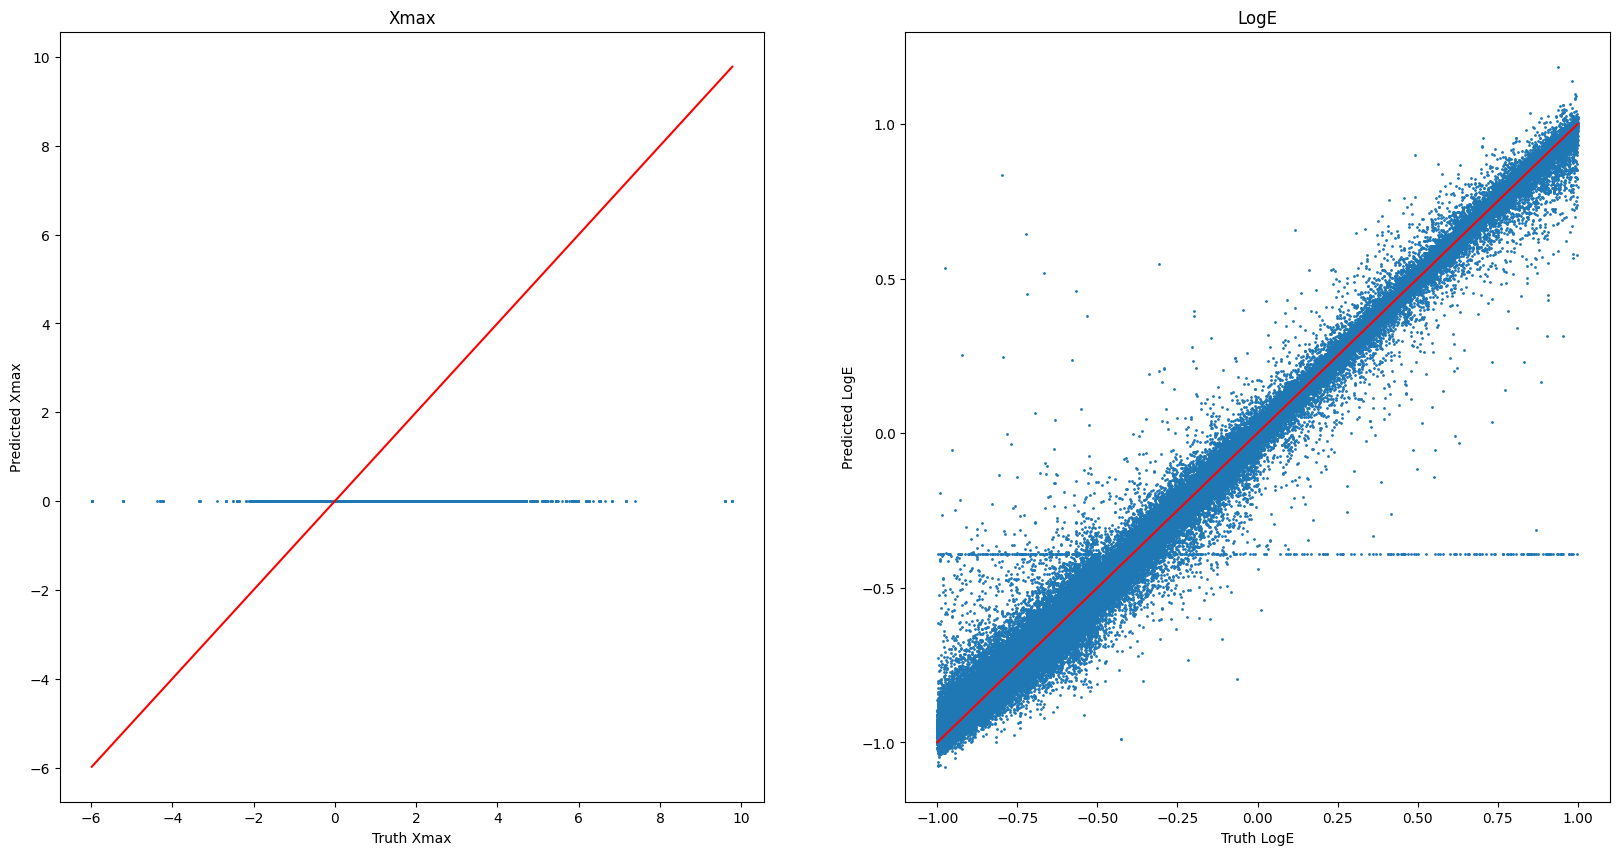

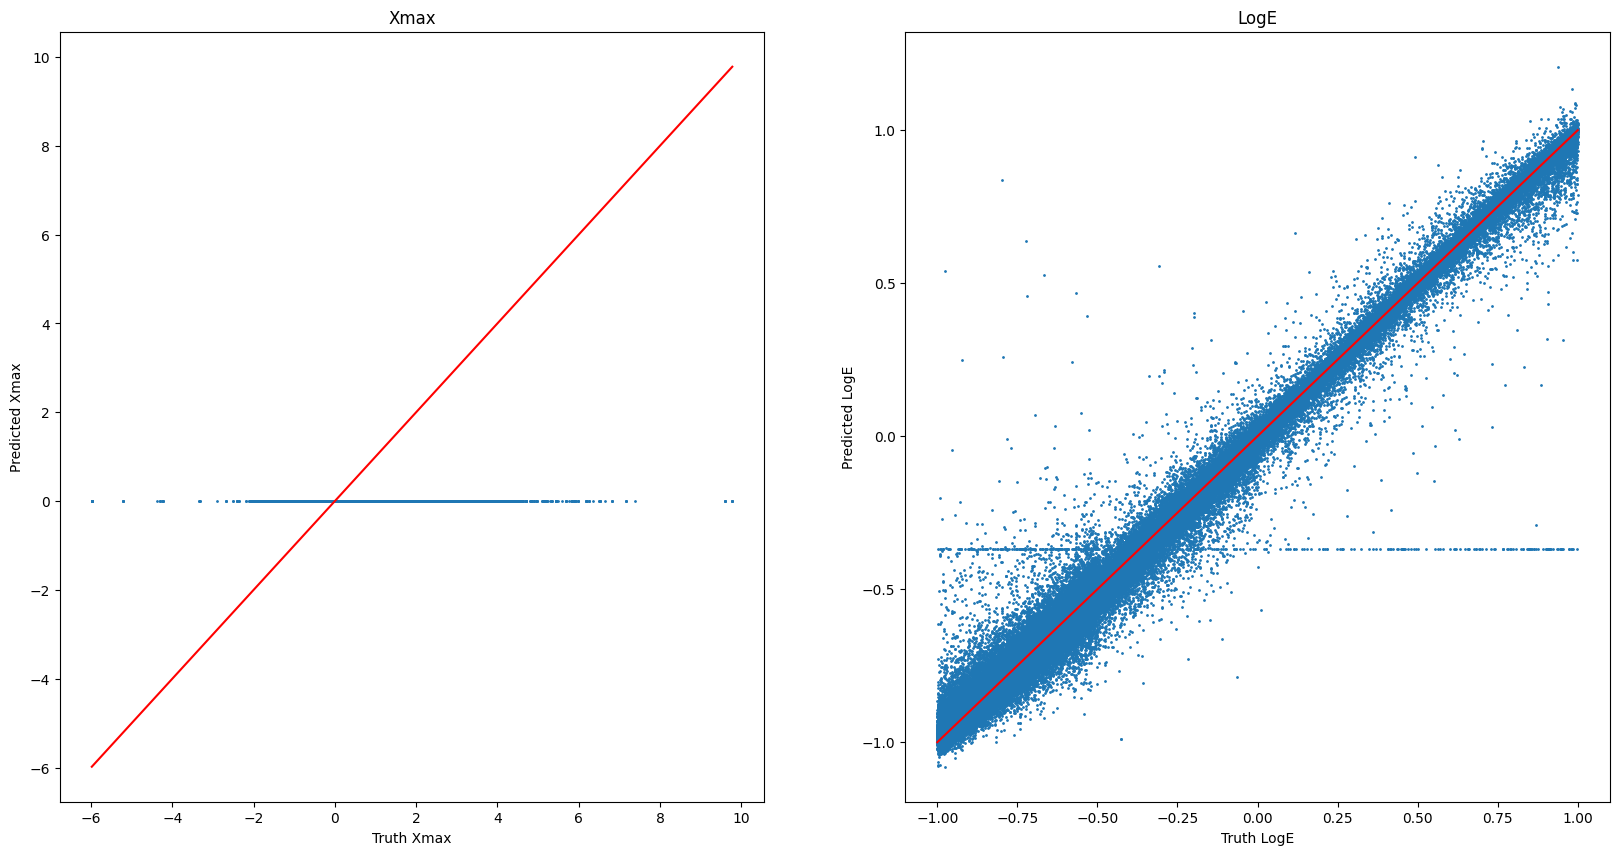

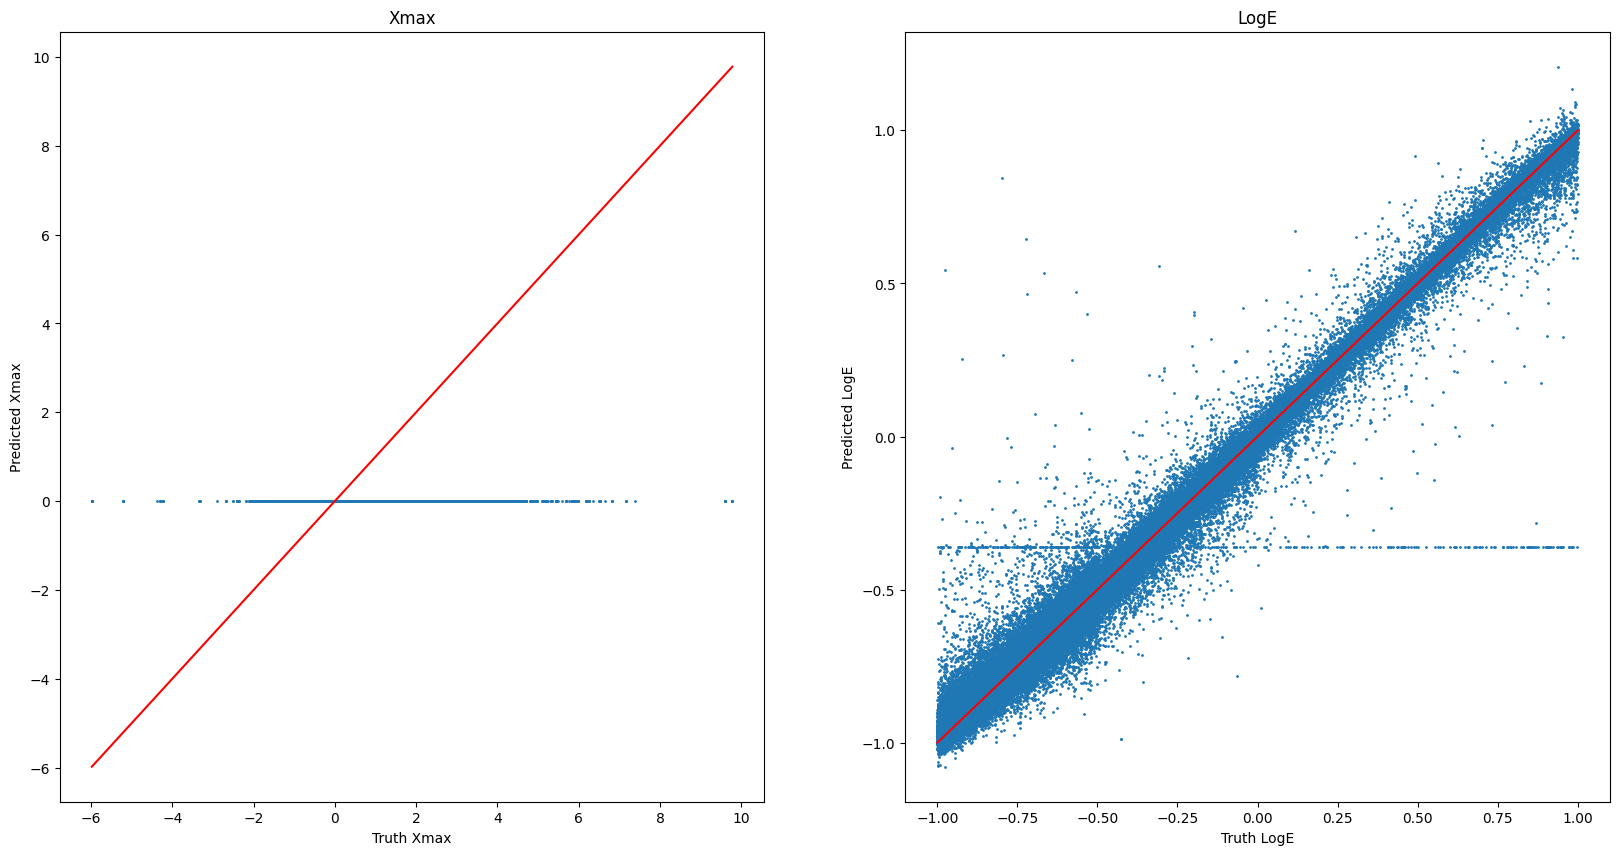

In [120]:
model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
                      plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)

In [89]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [121]:
# Compute the Test Set
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model.to(device)
torch.cuda.empty_cache()

ProcDS.State      = 'Test'
# ProcDS.BatchSize  = len(ProcDS)//256
ProcDS.BatchSize  = 1024
ProcDS.RandomIter = False
Truth = []
Pred  = []
Rec   = []
model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in ProcDS:
        # print(f'Event {EvI}/{len(ProcDS)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = ProcDS._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = ProcDS.Unnormalise_Truth(Truth)
Pred  = ProcDS.Unnormalise_Truth(Pred)
Rec   = ProcDS.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.4588192403316498
Rec  Loss inf
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(74070, 2)
(74070, 2)


In [122]:
# Compute Metric
TruthKeys  = ProcDS.Truth_Keys
TruthUnits = ProcDS.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred Xmax       62.74 g/cm^2
Adjusted Percentile for Rec  Xmax       20.599 g/cm^2
Percentile Ratio   Pred/Rec             3.0457

Adjusted Percentile for Pred LogE       0.031246 
Adjusted Percentile for Rec  LogE       0.029501 
Percentile Ratio   Pred/Rec             1.0592



In [123]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color='black')
        sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color='black')

        sns.histplot(x=X, y=Yp, ax=ax[0,i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[1,i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[0,i].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[1,i].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[0,i].set_ylabel(f'Model-Truth (degrees)')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[1,i].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[0,i].set_title(f'{TruthKeys[i]} - Model')
        ax[1,i].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[0,i].set_xlim(min(X),max(X))
        ax[1,i].set_xlim(min(X),max(X))

        ax[0,i].grid()
        ax[1,i].grid()

        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[0,i].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[1,i].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[0,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[0,i].transAxes, fontsize=15)
            ax[1,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[1,i].transAxes, fontsize=15)

        else:
            ax[0,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[0,i].transAxes, fontsize=15)
            ax[1,i].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[1,i].transAxes, fontsize=15)



        ax[0,i].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[0,i].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[1,i].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[1,i].axhline(-Percentile68_r, color='cyan', linestyle='--')

    return fig
    
# figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Name}_Combined_Deviation.png')

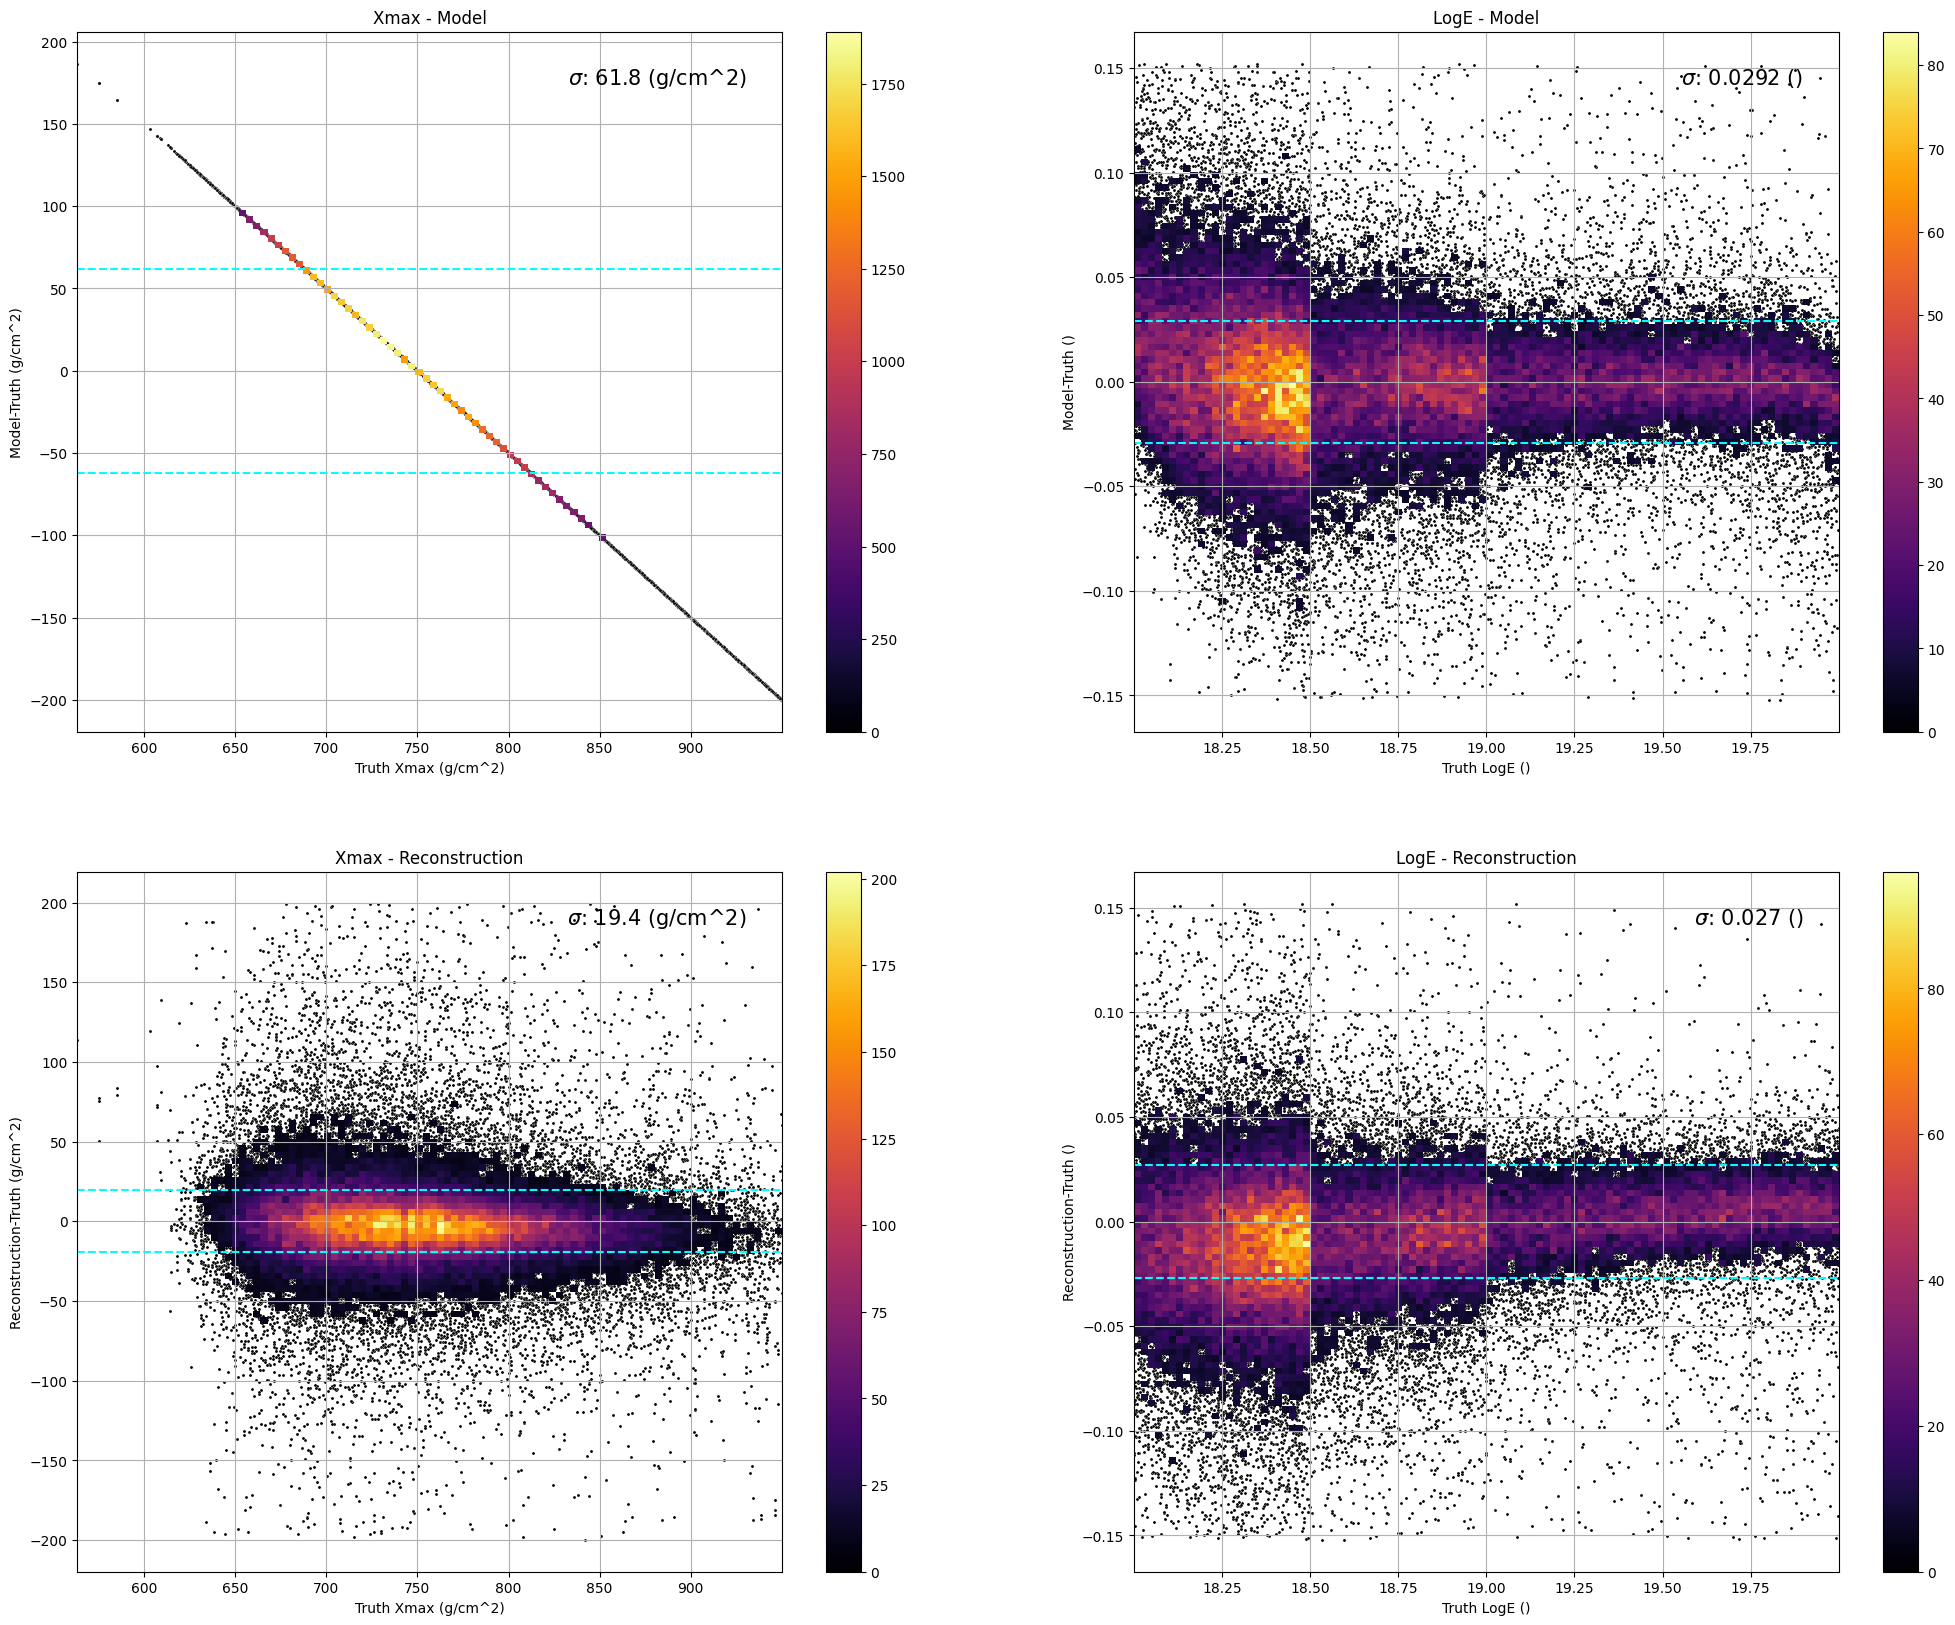

In [124]:
TruthKeys = ['Xmax','LogE']
TruthUnits = ['g/cm^2','']

figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)

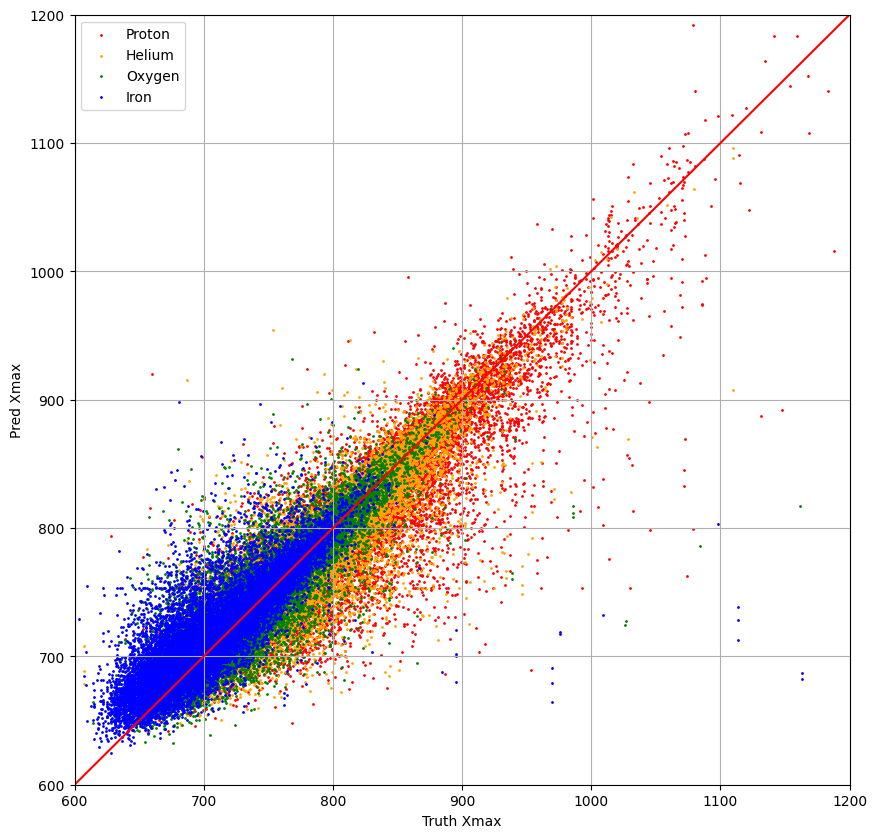

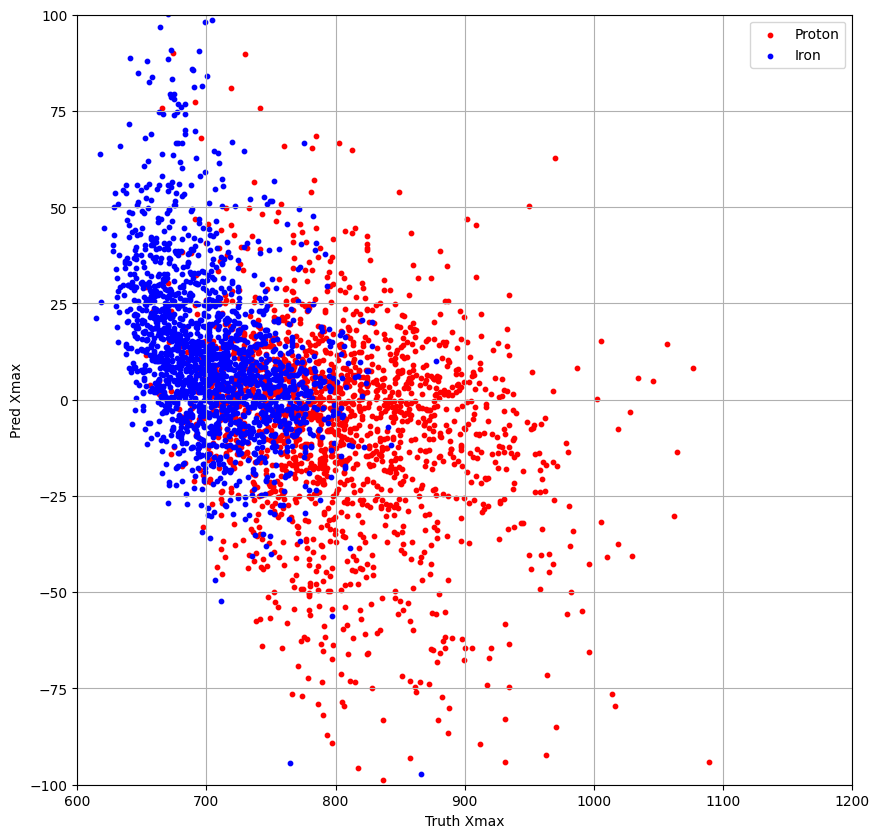

In [110]:
MetaData = ProcDS._MetaData[ProcDS.ActiveIndeces]
Primary = MetaData[:,0]

fig = plt.figure(figsize=(10,10))

colors = ['red','orange','green','blue']

for i,(primary,PrimaryName) in enumerate(zip([2212,2004,8016,26056],['Proton','Helium','Oxygen','Iron'])):
    cut = Primary == primary
    plt.scatter(Truth[cut,0],Pred[cut,0],label=f'{PrimaryName}',s=1,color=colors[i])
plt.plot([600,1200],[600,1200],'r')
plt.xlabel('Truth Xmax')
plt.ylabel('Pred Xmax')
plt.xlim(600,1200)
plt.ylim(600,1200)
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(10,10))


# for i,(primary,PrimaryName) in enumerate(zip([2212,2004,8016,26056],['Proton','Helium','Oxygen','Iron'])):
for i,(primary,PrimaryName,ThisColor) in enumerate(zip([2212,26056],['Proton','Iron'],['red','blue'])):
    cut = (Primary.numpy() == primary)
    # Randomly thin out the values
    mask = np.zeros(len(Truth),dtype=bool)
    mask[:int(0.1*len(Truth))] = True
    np.random.shuffle(mask)
    cut = mask*cut
    # print(cut.sum())
    plt.scatter(Truth[cut,0],Pred[cut,0]-Truth[cut,0],label=f'{PrimaryName}',s=10,color=ThisColor)
# plt.plot([600,1200],[600,1200],'r')
plt.xlabel('Truth Xmax')
plt.ylabel('Pred Xmax')
plt.xlim(600,1200)
plt.ylim(-100,100)
plt.legend()
plt.grid()
plt.show()



In [ ]:
# model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
#                       plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)


In [ ]:
# model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
#                       plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)


In [85]:
# torch.save(model  ,SavePath+model.Name+'.pt')
# torch.save(tracker,SavePath+model.Name+'_Tracker.pt')

# Trying Recurrent Model below

In [81]:
# # Define Loss, Validation and Metric Here

# def Loss(Pred,Truth,keys=['Xmax','LogE'],ReturnTensor = True):

#     '''
#     Calculates MSE Loss for all the keys in the keys list
#     '''
#     assert Pred.shape[0] == Truth.shape[0], f'Pred Shape: {Pred.shape}, Truth Shape: {Truth.shape} not equal'
#     Truth = Truth.to(Pred.device)
#     print(Pred[0])
#     # print(Truth[0])
#     # Calculate Loss
#     losses = {}
#     for i,key in enumerate(keys):
#         if key == 'Xmax':
#             true_bins = ((Truth[:,i]*70+750)/5).long()
#             print(true_bins)
#             losses[key] = F.cross_entropy(Pred[:,:400],true_bins)
#         else:
#             losses[key] = F.mse_loss(Pred[:,399+i],Truth[:,i])
    
#     losses['Total'] = sum(losses.values())
#     if ReturnTensor: return losses
#     else:
#         losses = {key:loss.item() for key,loss in losses.items()}
#         return losses


# def validate(model,Dataset,Loss,device,BatchSize = 1024):
#     '''
#     Takes model, Dataset, Loss Function, device, keys
#     Dataset is defined as ProcessingDatasetContainer in the Dataset2.py
#     keys are to be used in the loss function
#     BatchSize to change in case it doesnt fit into memory
#     Returns the average loss
#     '''
#     # make sure the Dataset State is Val
#     Dataset.State = 'Val'
#     model.eval()
#     TrainingBatchSize = Dataset.BatchSize
#     Dataset.BatchSize = BatchSize
#     Preds  = []
#     Truths = []
#     with torch.no_grad():
#         for _, BatchMains, BatchAux, BatchTruth,_  in Dataset:
            
#             Preds .append( model(BatchMains,BatchAux).to('cpu'))
#             Truths.append(       BatchTruth          .to('cpu'))
#         Preds  = torch.cat(Preds ,dim=0)
#         Truths = torch.cat(Truths,dim=0)

#     # Return Batch Size to old value
#     Dataset.BatchSize = TrainingBatchSize
#     return Loss(Preds,Truths,keys=Dataset.Truth_Keys,ReturnTensor=False)


# def metric(model,Dataset,device,keys = ['Xmax','LogE'],BatchSize = 1024):
#     '''
#     Takes model, Dataset, Loss Function, device, keys
#     Dataset is defined as ProcessingDatasetContainer in the Dataset2.py
#     keys are to be used in the loss function
#     BatchSize to change in case it doesnt fit into memory
#     Returns the 68% containment range of the angular deviation
#     '''
#     # make sure the Dataset State is Val
#     Dataset.State = 'Val'
#     model.eval()
#     TrainingBatchSize = Dataset.BatchSize
#     Dataset.BatchSize = BatchSize
#     Preds  = []
#     Truths = []
#     with torch.no_grad():
#         for _, BatchMains, BatchAux, BatchTruth, _ in Dataset:
#             Preds .append( model(BatchMains,BatchAux).to('cpu'))
#             Truths.append(       BatchTruth          .to('cpu'))
#     Preds  = torch.cat(Preds ,dim=0).cpu()
#     Truths = torch.cat(Truths,dim=0).cpu()
#     XmaxPred = ((torch.argmax(Preds[:,:400],dim=1)*5-750)/70).unsqueeze(1)
#     LogEPred = Preds[:,400:]
#     # print(XmaxPred.shape,LogEPred.shape)
#     Preds = torch.cat([XmaxPred,LogEPred],dim=1)
#     Preds  = Dataset.Unnormalise_Truth(Preds )
#     Truths = Dataset.Unnormalise_Truth(Truths)

#     Units = Dataset.Truth_Units
#     metrics = {}
#     for i,key in enumerate(keys):
#         if Units[i] == 'rad':
#             AngDiv = torch.atan2(torch.sin(Preds[:,i]-Truths[:,i]),torch.cos(Preds[:,i]-Truths[:,i]))
#             metrics[key] = torch.quantile(torch.abs(AngDiv),0.68)
#         if Units[i] == 'deg':
#             AngDiv = torch.atan2(torch.sin(torch.deg2rad(Preds[:,i]-Truths[:,i])),torch.cos(torch.deg2rad(Preds[:,i]-Truths[:,i])))
#             metrics[key] = torch.quantile(torch.abs(AngDiv),0.68)*180/torch.pi
#         else:
#             metrics[key] = torch.quantile(torch.abs(Preds[:,i]-Truths[:,i]),0.68)
#     # Return Batch Size to old value
#     Dataset.BatchSize = TrainingBatchSize
#     return metrics


In [82]:
# class Model_XmaxE_LSTM_TracePred(nn.Module):

#     Name = 'Model_XmaxE_LSTM_TracePred'
#     Description = 'Model to predict Xmax and Energy using LSTM and Trace Prediction, The LogE isnt really predicted, just need it to match the truth values. Xmax is predicted as probability that Xmax is in a bin -> 400 bin array'

#     def __init__(self, N_LSTM_nodes=16, N_LSTM_layers=5, **kwargs):

#         self.kwargs = kwargs
#         super(Model_XmaxE_LSTM_TracePred, self).__init__()

#         # Input is a 1 channels of 400 bins each
#         self.LSTM = nn.LSTM(1, N_LSTM_nodes, N_LSTM_layers, batch_first = True, dropout = 0.1, bidirectional = True)
#         self.LSTM_Collect = nn.LSTM(2*N_LSTM_nodes, 1, 1, batch_first = True, dropout = 0, bidirectional = False)

#         self.FinalActivation = nn.Softmax(dim=1)
        
#     def forward(self,x,aux):
#         x = x[0].unsqueeze(2)
#         # print(x.shape)
#         device = self.LSTM.weight_ih_l0.device
#         x = x.to(device)
#         # aux = aux.to(device) # not using aux for now

#         # LSTM Layers
#         x, _ = self.LSTM(x)
#         x, _ = self.LSTM_Collect(x)
#         x = self.FinalActivation(x.squeeze(2))
#         # print(x[0])

#         return torch.cat([x,torch.zeros(x.shape[0],1).to(x.device)],dim=1)
    


In [83]:
# # Load the model and axuillary functions
# import TrainingModule
# importlib.reload(TrainingModule)
# Tracker = TrainingModule.Tracker
# Train   = TrainingModule.Train

# Model = Model_XmaxE_LSTM_TracePred

# Loss_function = Loss
# # validate      = validate
# # metric        = metric


# # Setup the model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# # Model Parameters
# Model_Parameters = {
#     'in_main_channels': (3,),
#     'in_node_channels': 5   ,
#     'in_edge_channels': 2   ,
#     'in_aux_channels' : 1   ,
#     'N_kernels'       : 16   ,
#     'N_Graph_Heads'   : 2   ,
#     'N_dense_nodes'   : 1128  ,
#     'N_LSTM_nodes'    : 16  ,
#     'N_LSTM_layers'   : 1   ,
#     'kernel_size'     : 10  ,
#     'conv2d_init_type': 'normal',
#     'model_Dropout'   : 0.2
#     }


# Training_Parameters = {
#         'LR': 0.0001,
#         'epochs': 5,
#         'BatchSize': ProcDS.BatchSize, # In notebook set during loading
#         'accumulation_steps': 1,
#         'epoch_done': 0,
#         'batchBreak': 1e99,
#         'ValLossIncreasePatience': 15,
#         'Optimizer': 'Adam'
#     }


# model = Model(**Model_Parameters).to(device)

# if Training_Parameters['Optimizer'] == 'Adam': optimizer = optim.Adam(model.parameters(), lr=Training_Parameters['LR'])
# if Training_Parameters['Optimizer'] == 'SGD' : optimizer = optim.SGD (model.parameters(), lr=Training_Parameters['LR'], momentum=0.9)
# # Define scheduler
# gamma = 0.001**(1/30) if Training_Parameters['epochs']>30 else 0.001**(1/Training_Parameters['epochs']) # Reduce the LR by factor of 1000 over 30 epochs or less
# scheduler = torch.optim.lr_scheduler.ExponentialLR    (optimizer, gamma = gamma, last_epoch=-1, verbose=False)



In [84]:
# model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
#                       plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)
